In [1]:
import pandas as pd

dfs=[]

for s in ["anger","joy","sadness","fear"]:
    dfs.append(pd.read_csv(f"./dataset/WassaTrainData_{s}.txt", sep="\t",header=None, names=["index","content","sentiment","intensity"]))   
df=pd.concat(dfs,axis=0).sample(frac=1).reset_index(drop=True)
print("Number of records:",len(df))
df.drop(["index","intensity"],axis=1,inplace=True)
df.head()

Number of records: 3613


,content,sentiment
0,@EAMaddenNFL @EASPORTS I played a game where J...,anger
1,@V_of_Europe @ckolacia MSM relentlessly saying...,sadness
2,@OC_Transpo some weeks there are no problems b...,fear
3,In wake of fresh #terror threat and sounding o...,fear
4,@JogglingDroid @BrancoCarmine @Otto_English ye...,fear


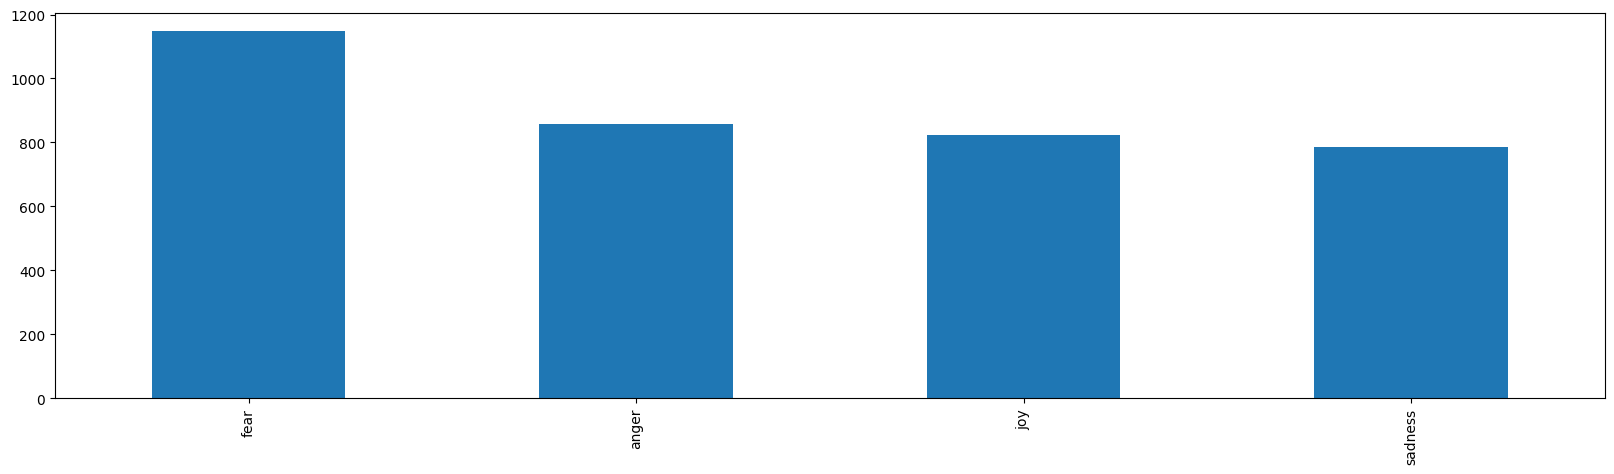

In [2]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (20, 5)})
df.sentiment.value_counts().plot(kind='bar')
plt.show()


In order to have a larger dataset, we are going to import test data from the Wassa 2017 competition and use them as train data.

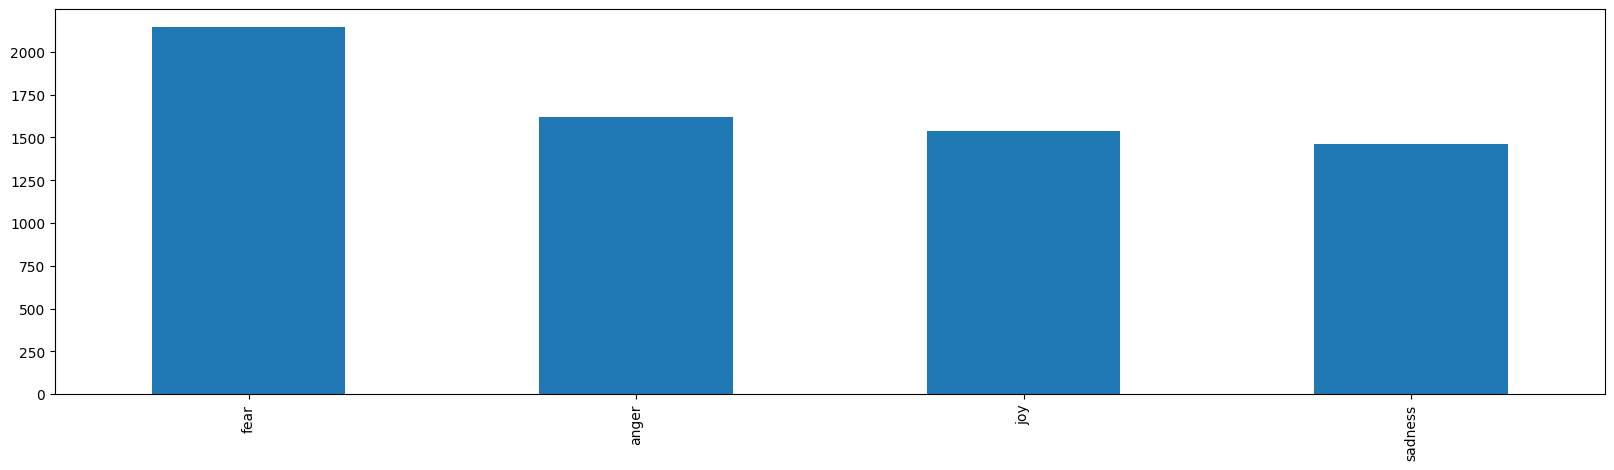

In [3]:
dfs=[df]
for s in ["anger","joy","sadness","fear"]:
    df_temp=pd.read_csv(f"./dataset/WassaTrainData_{s}_2.txt", sep="\t",header=None, names=["index","content","sentiment","intensity"])
    df_temp.drop(["index","intensity"],axis=1,inplace=True)
    dfs.append(df_temp)   

df=pd.concat(dfs,axis=0).sample(frac=1).reset_index(drop=True)

plt.rcParams.update({'figure.figsize': (20, 5)})
df.sentiment.value_counts().plot(kind='bar')
plt.show()

Now let's undersample the dataset so that it can be more balanced.

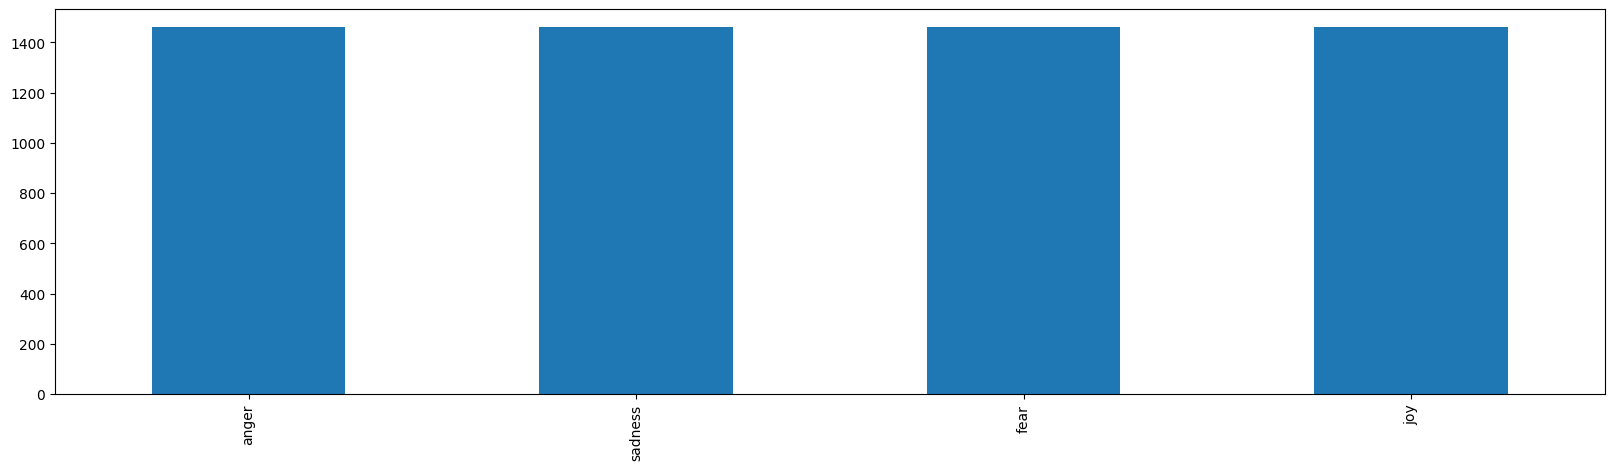

In [4]:
num_fear=len(df[df['sentiment']=='fear'])
num_anger=len(df[df['sentiment']=='anger'])
num_joy=len(df[df['sentiment']=='joy'])
num_sadness=len(df[df['sentiment']=='sadness'])
num_per_sentiment=min(num_fear,num_anger,num_joy,num_sadness)   #find the the category with the least number of records

fear_sample=df[df['sentiment']=='fear'].sample(frac=num_per_sentiment/num_fear)    #select a number of records equal to the least number
anger_sample=df[df['sentiment']=='anger'].sample(frac=num_per_sentiment/num_anger) 
joy_sample=df[df['sentiment']=='joy'].sample(frac=num_per_sentiment/num_joy)
sadness_sample=df[df['sentiment']=='sadness'].sample(frac=num_per_sentiment/num_sadness)

df=pd.concat([fear_sample,anger_sample,joy_sample,sadness_sample],axis=0).sample(frac=1).reset_index(drop=True) #concatenate the samples, shuffle and reset index

df.sentiment.value_counts().plot(kind='bar')
plt.show()


In [6]:
#a function that tokenize the text using nltk library
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import contractions
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess(sentence):
    not_contracted=[contractions.fix(w) for w in sentence.split()]
    filtered_words = [word for word in not_contracted if not word.startswith('@')] #remove mentions
    filtered_words = [word for word in filtered_words if not word.startswith('http')] #remove urls
    sentence = ' '.join(filtered_words) 
    tokens = word_tokenize(sentence)    #tokenization
    tokens = [w.lower() for w in tokens]    #remove the upper case
    table = str.maketrans('', '', string.punctuation)   #remove punctuation
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]    #remove words with numbers
    stop_words = stopwords.words('english')
    stop_words.remove("not")    #preserve negative terms because they could be significant to determine sentiment
    stop_words.remove("no")     
    stop_words.remove("nor")
    words = [w for w in words if not w in stop_words]   #remove stop words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]    #lemmatize
    return words


df["tokens"]=df['content'].apply(preprocess)
df["joined_tokens"]=df['tokens'].apply(lambda x: ' '.join(x))

df.head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alessio\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alessio\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alessio\AppData\Roaming\nltk_data...


,content,sentiment,tokens,joined_tokens
0,Went n a bodega 4 incense lookd @ the sis behi...,anger,"[went, n, bodega, incense, lookd, si, behind, ...",went n bodega incense lookd si behind counter ...
1,"It is a solemn thing, and no small scandal in ...",sadness,"[solemn, thing, no, small, scandal, kingdom, s...",solemn thing no small scandal kingdom see god ...
2,@corruptmelon now im feeling the #worry,fear,"[feeling, worry]",feeling worry
3,#LethalWeapon A suicidal Vet with PTSD... so F...,joy,"[lethalweapon, suicidal, vet, ptsd, fucking, f...",lethalweapon suicidal vet ptsd fucking funny l...
4,"God just replaced my sadness with laughter, ca...",sadness,"[god, replaced, sadness, laughter, not, go, wh...",god replaced sadness laughter not go whole day...


In [7]:
#removing duplicated text if present

if not df[df['joined_tokens'].duplicated() == True].empty:
    print("The dataset has some duplicated records!")
    print("Removing...")
    df = df.drop_duplicates(subset='joined_tokens', keep='first')
    print("Done")
else:
    print("The dataset has no duplicated rows!")

The dataset has some duplicated records!
Removing...
Done


# Bag od Words

## Multinomial Logistic Regression

Model parameters:  ((1, 2), 'lbfgs')
Accuracy:  0.8933333333333333
Classification report: 
               precision    recall  f1-score   support

       anger       0.90      0.90      0.90       282
        fear       0.91      0.86      0.88       286
         joy       0.89      0.94      0.91       279
     sadness       0.88      0.87      0.88       278

    accuracy                           0.89      1125
   macro avg       0.89      0.89      0.89      1125
weighted avg       0.89      0.89      0.89      1125



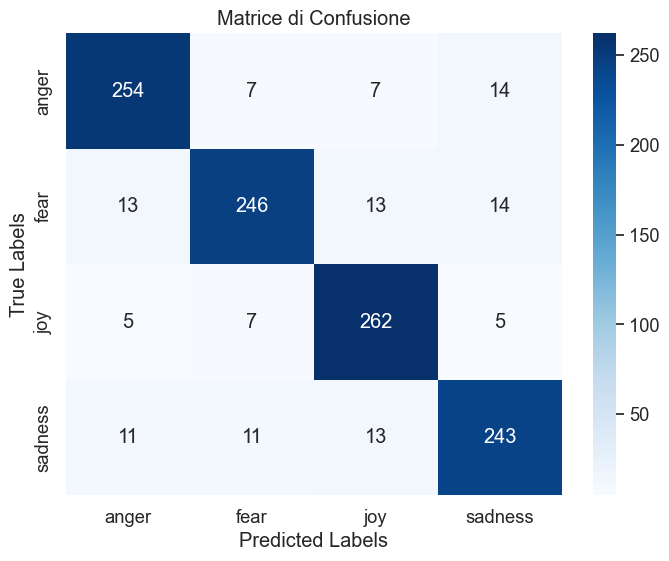

In [32]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df["joined_tokens"], df["sentiment"], test_size=0.2, stratify=df["sentiment"])

ngrams=[(1,1),(1,2),(2,2),(1,3),(2,3),(3,3)]
solvers=['lbfgs', 'liblinear']
accuracies={}
for ngram in ngrams:
    for solv in solvers:

        logreg = make_pipeline(TfidfVectorizer(ngram_range=ngram), LogisticRegression(solver=solv))
        logreg.fit(X_train, y_train)
        y_pred=logreg.predict(X_test)

        accuracies[(ngram,solv)]=accuracy_score(y_test, y_pred) #save the accuracy of each model in order to compare them and select the best one

#order accuracies by values
sorted_accuracies=sorted(accuracies.items(), key=lambda x: x[1], reverse=True)

#re train the model with the best parameters 
logreg = make_pipeline(TfidfVectorizer(ngram_range=sorted_accuracies[0][0][0]), LogisticRegression(solver=sorted_accuracies[0][0][1]))
logreg.fit(X_train, y_train)
y_pred=logreg.predict(X_test)

print("Model parameters: ", sorted_accuracies[0][0])
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification report: \n",classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(set(y_test)),
            yticklabels=sorted(set(y_test)))

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Matrice di Confusione')
plt.show()


## Random Forest

Model parameters:  ((1, 3), 100, 'entropy')
Accuracy: 0.8808888888888889
Classification report: 
 <function classification_report at 0x0000017FF13996C0>


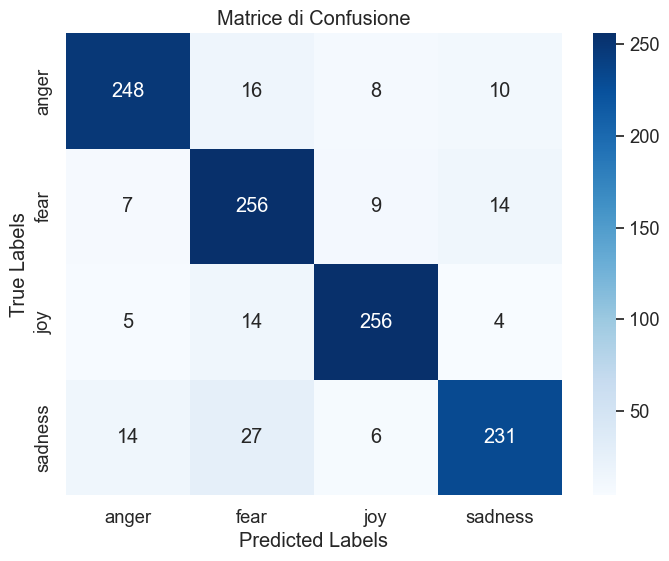

In [33]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(df["joined_tokens"], df["sentiment"], test_size=0.2, stratify=df["sentiment"])

ngrams=[(1,1),(1,2),(2,2),(1,3),(2,3),(3,3)]
n_estimators=[50,100,150,200]
losses=['gini', 'entropy', 'log_loss']
accuracies={}
for ngram in ngrams:
    for n_est in n_estimators:
        for loss in losses:
            rfc = make_pipeline(TfidfVectorizer(ngram_range=ngram), RandomForestClassifier(n_estimators=n_est, criterion=loss))
            rfc.fit(X_train, y_train)
            y_pred=rfc.predict(X_test)
            accuracies[(ngram,n_est,loss)]=accuracy_score(y_test, y_pred)

#order accuracies by values
sorted_accuracies=sorted(accuracies.items(), key=lambda x: x[1], reverse=True)

#re train the model with the best parameters
rfc = make_pipeline(TfidfVectorizer(ngram_range=sorted_accuracies[0][0][0]), 
                    RandomForestClassifier(n_estimators=sorted_accuracies[0][0][1], criterion=sorted_accuracies[0][0][2]))
rfc.fit(X_train, y_train)
y_pred=rfc.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
print("Model parameters: ", sorted_accuracies[0][0])
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report: \n",classification_report)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(set(y_test)),
            yticklabels=sorted(set(y_test)))

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Matrice di Confusione')
plt.show()

## SVM


Model parameters:  ((1, 2), 'sigmoid')
Accuracy: 0.9111111111111111
Classification Report:
               precision    recall  f1-score   support

       anger       0.94      0.93      0.93       282
        fear       0.89      0.89      0.89       286
         joy       0.93      0.92      0.93       279
     sadness       0.89      0.90      0.89       278

    accuracy                           0.91      1125
   macro avg       0.91      0.91      0.91      1125
weighted avg       0.91      0.91      0.91      1125



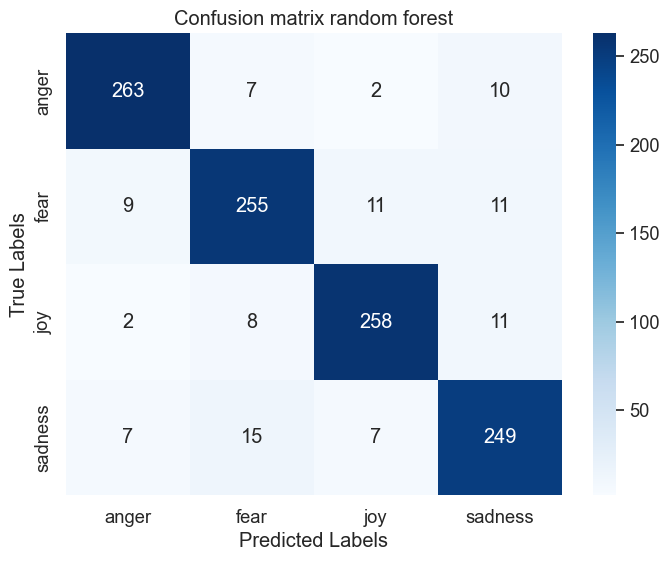

In [35]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(df["joined_tokens"], df["sentiment"], test_size=0.2, stratify=df["sentiment"])

ngrams=[(1,1),(1,2),(2,2),(1,3),(2,3),(3,3)]
kernels=['linear', 'poly', 'rbf', 'sigmoid']
accuracies={}
for ngram in ngrams:
    for k in kernels:
        svm= make_pipeline(TfidfVectorizer(ngram_range=ngram),SVC(kernel=k))
        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)
        accuracies[(ngram,k)]=accuracy_score(y_test, y_pred)

#order accuracies by values
sorted_accuracies=sorted(accuracies.items(), key=lambda x: x[1], reverse=True)

svm= make_pipeline(TfidfVectorizer(ngram_range=sorted_accuracies[0][0][0]),SVC(kernel=sorted_accuracies[0][0][1]))
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)


#print results
print("Model parameters: ", sorted_accuracies[0][0])
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

#confusion matrix
confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(set(y_test)),
            yticklabels=sorted(set(y_test)))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion matrix random forest')
plt.show()

# Glove

In [11]:
from gensim.models import KeyedVectors
import numpy as np

# Load pre trained glove
embeddings_model_100 = KeyedVectors.load_word2vec_format('glove.6B/glove.6B.100d.txt', binary=False, no_header=True)
embeddings_model_200 = KeyedVectors.load_word2vec_format('glove.6B/glove.6B.200d.txt', binary=False, no_header=True)
embeddings_model_300 = KeyedVectors.load_word2vec_format('glove.6B/glove.6B.300d.txt', binary=False, no_header=True)

def tokens2vec(tokens,emb_model,dim,method='mean'):
    embeddings = []
    for token in tokens:
        try:
            embedding = emb_model[token]  
            embeddings.append(embedding)
        except KeyError:
            pass
    if embeddings:
        if method=='mean':
            return np.mean(embeddings, axis=0)
        elif method=='sum':
            return np.sum(embeddings, axis=0)
    else:
        return np.zeros(dim)



## Logistic Regression

Model with vector size 300 and solver liblinear 
Accuracy:  0.7019572953736655
Classification Report:
                precision    recall  f1-score   support

       anger       0.69      0.73      0.71       285
        fear       0.65      0.68      0.67       283
         joy       0.80      0.74      0.77       278
     sadness       0.68      0.66      0.67       278

    accuracy                           0.70      1124
   macro avg       0.70      0.70      0.70      1124
weighted avg       0.70      0.70      0.70      1124



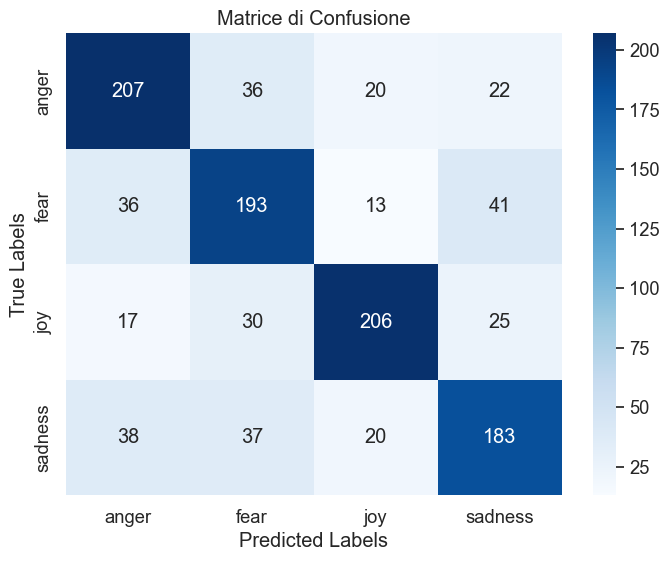

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(df["tokens"], df["sentiment"], test_size=0.2, stratify=df["sentiment"])
X_train_100=np.array([tokens2vec(t,embeddings_model_100,100) for t in X_train])
X_test_100=[tokens2vec(t,embeddings_model_100,100) for t in X_test]
X_train_200=np.array([tokens2vec(t,embeddings_model_200,200) for t in X_train])
X_test_200=[tokens2vec(t,embeddings_model_200,200) for t in X_test]
X_train_300=np.array([tokens2vec(t,embeddings_model_300,300) for t in X_train])
X_test_300=[tokens2vec(t,embeddings_model_300,300) for t in X_test]
y_test=y_test.values
y_train=y_train.values

accuracies={}
for dim in [100,200,300]:
    for solv in ['lbfgs','liblinear']:
        
        logistic_regression = LogisticRegression(max_iter=1000,solver=solv)

        if dim== 100: 
            logistic_regression.fit(X_train_100, y_train)
            y_pred = logistic_regression.predict(np.array(X_test_100))
        elif dim==200: 
            logistic_regression.fit(X_train_200, y_train)
            y_pred = logistic_regression.predict(np.array(X_test_200))
        else: 
            logistic_regression.fit(X_train_300, y_train)
            y_pred = logistic_regression.predict(np.array(X_test_300))
        
        accuracies[(dim,solv)]=accuracy_score(y_test,y_pred)
        
sorted_accuracies=sorted(accuracies.items(), key=lambda x: x[1], reverse=True)


logistic_regression = LogisticRegression(max_iter=1000,solver=sorted_accuracies[0][0][1])
if sorted_accuracies[0][0][0]==100:
    logistic_regression.fit(X_train_100, y_train)
    y_pred = logistic_regression.predict(np.array(X_test_100))
elif sorted_accuracies[0][0][0]==200:
    logistic_regression.fit(X_train_200, y_train)
    y_pred = logistic_regression.predict(np.array(X_test_200))
else:
    logistic_regression.fit(X_train_300, y_train)
    y_pred = logistic_regression.predict(np.array(X_test_300))
print(f"Model with vector size {sorted_accuracies[0][0][0]} and solver {sorted_accuracies[0][0][1]} ")
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Classification Report:\n ',classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(set(y_test)),
            yticklabels=sorted(set(y_test)))

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Matrice di Confusione')
plt.show()

## Random Forest

Model with vector size 300, 200 trees and criterion=log_loss 
Accuracy:  0.6752669039145908
Classification Report:
                precision    recall  f1-score   support

       anger       0.65      0.78      0.71       285
        fear       0.67      0.63      0.65       283
         joy       0.72      0.74      0.73       278
     sadness       0.66      0.55      0.60       278

    accuracy                           0.68      1124
   macro avg       0.68      0.67      0.67      1124
weighted avg       0.68      0.68      0.67      1124



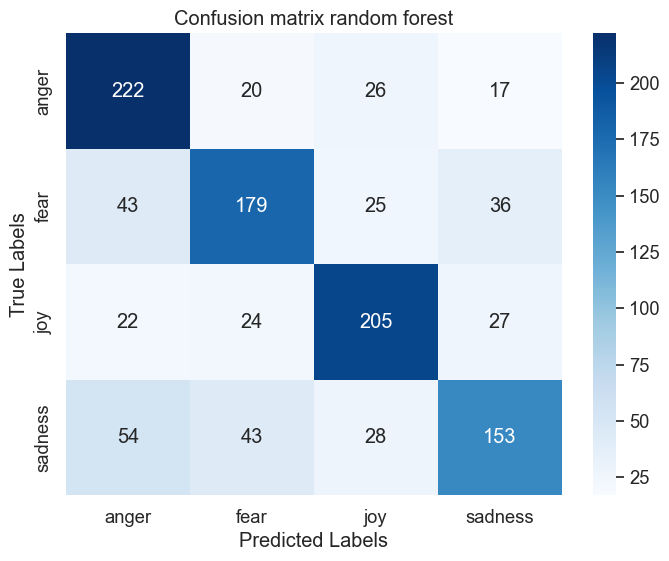

In [12]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(df["tokens"], df["sentiment"], test_size=0.2, stratify=df["sentiment"])
X_train_100=np.array([tokens2vec(t,embeddings_model_100,100) for t in X_train])
X_test_100=[tokens2vec(t,embeddings_model_100,100) for t in X_test]
X_train_200=np.array([tokens2vec(t,embeddings_model_200,200) for t in X_train])
X_test_200=[tokens2vec(t,embeddings_model_200,200) for t in X_test]
X_train_300=np.array([tokens2vec(t,embeddings_model_300,300) for t in X_train])
X_test_300=[tokens2vec(t,embeddings_model_300,300) for t in X_test]
y_test=y_test.values
y_train=y_train.values

losses=['gini', 'entropy', 'log_loss']
n_estim=[50,100,200]
accuracies={}
for dim in [100,200,300]:
    for n in n_estim:
        for loss in losses:

            rfc = RandomForestClassifier(n_estimators=n,criterion=loss)
        if dim== 100: 
            rfc.fit(X_train_100, y_train)
            y_pred = rfc.predict(np.array(X_test_100))
        elif dim==200: 
            rfc.fit(X_train_200, y_train)
            y_pred = rfc.predict(np.array(X_test_200))
        else: 
            rfc.fit(X_train_300, y_train)
            y_pred = rfc.predict(np.array(X_test_300))
        
        accuracies[(dim,n,loss)]=accuracy_score(y_test,y_pred)

sorted_accuracies=sorted(accuracies.items(), key=lambda x: x[1], reverse=True)
 
rfc = RandomForestClassifier(n_estimators=sorted_accuracies[0][0][1],criterion=sorted_accuracies[0][0][2])
if sorted_accuracies[0][0][0]==100:
    rfc.fit(X_train_100, y_train)
    y_pred = rfc.predict(np.array(X_test_100))
elif sorted_accuracies[0][0][0]==200:
    rfc.fit(X_train_200, y_train)
    y_pred = rfc.predict(np.array(X_test_200))
else:
    rfc.fit(X_train_300, y_train)
    y_pred = rfc.predict(np.array(X_test_300))

print(f"Model with vector size {sorted_accuracies[0][0][0]}, {sorted_accuracies[0][0][1]} trees and criterion={sorted_accuracies[0][0][2]} ")
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Classification Report:\n ',classification_report(y_test, y_pred))
#confusion matrix
confusion = confusion_matrix(y_test, y_pred)
#plot confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(set(y_test)),
            yticklabels=sorted(set(y_test)))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion matrix random forest')
plt.show()


## SVM

Model with vector size 300 and kerel=linear
Accuracy: 0.708185053380783
Classification Report:
               precision    recall  f1-score   support

       anger       0.69      0.71      0.70       285
        fear       0.68      0.67      0.67       283
         joy       0.78      0.77      0.77       278
     sadness       0.69      0.69      0.69       278

    accuracy                           0.71      1124
   macro avg       0.71      0.71      0.71      1124
weighted avg       0.71      0.71      0.71      1124



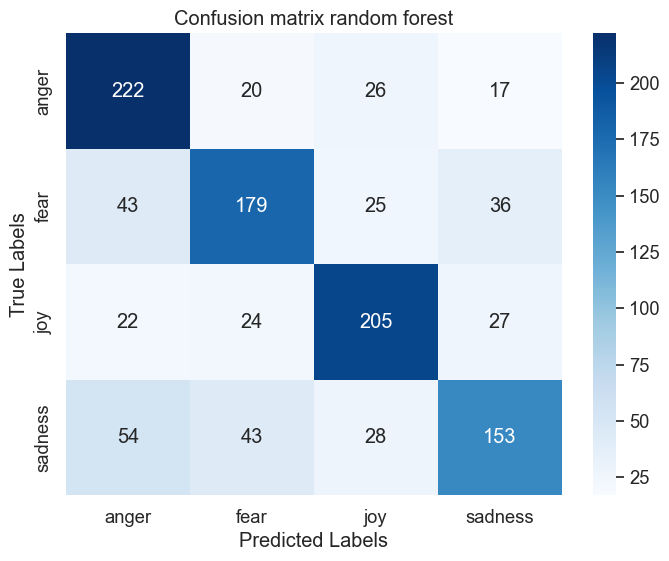

In [14]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(df["tokens"], df["sentiment"], test_size=0.2, stratify=df["sentiment"])
X_train_100=np.array([tokens2vec(t,embeddings_model_100,100) for t in X_train])
X_test_100=[tokens2vec(t,embeddings_model_100,100) for t in X_test]
X_train_200=np.array([tokens2vec(t,embeddings_model_200,200) for t in X_train])
X_test_200=[tokens2vec(t,embeddings_model_200,200) for t in X_test]
X_train_300=np.array([tokens2vec(t,embeddings_model_300,300) for t in X_train])
X_test_300=[tokens2vec(t,embeddings_model_300,300) for t in X_test]
y_test=y_test.values
y_train=y_train.values

kernels=['linear', 'poly', 'rbf', 'sigmoid']
accuracies={}

for dim in [100,200,300]:
    for k in kernels:

        svm = SVC(kernel='rbf') 

        if dim== 100: 
            svm.fit(X_train_100, y_train)
            y_pred = svm.predict(np.array(X_test_100))
        elif dim==200: 
            svm.fit(X_train_200, y_train)
            y_pred = svm.predict(np.array(X_test_200))
        else: 
            svm.fit(X_train_300, y_train)
            y_pred = svm.predict(np.array(X_test_300))
        
        accuracies[(dim,k)]=accuracy_score(y_test,y_pred)

sorted_accuracies=sorted(accuracies.items(), key=lambda x: x[1], reverse=True)

svm = SVC(kernel=sorted_accuracies[0][0][1]) 

if sorted_accuracies[0][0][0]==100:
    svm.fit(X_train_100, y_train)
    y_pred = svm.predict(np.array(X_test_100))
elif sorted_accuracies[0][0][0]==200:
    svm.fit(X_train_200, y_train)
    y_pred = svm.predict(np.array(X_test_200))
else:
    svm.fit(X_train_300, y_train)
    y_pred = svm.predict(np.array(X_test_300))

#print results
print(f"Model with vector size {sorted_accuracies[0][0][0]} and kerel={sorted_accuracies[0][0][1]}")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
#plot confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Imposta la dimensione del carattere per la heatmap
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(set(y_test)),
            yticklabels=sorted(set(y_test)))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion matrix random forest')
plt.show()

## NN

In [12]:
#first let's one hot encode the labels
def oneHotEncode(val,dictionary):
    arr=np.zeros(len(dictionary))
    arr[dictionary[val]]=1
    return arr

oneHotDict={key:val for val,key in enumerate(df.sentiment.unique())}

df['label']=df['sentiment'].apply(lambda x: oneHotEncode(x,oneHotDict))
df.head()

,content,sentiment,tokens,joined_tokens,label
0,@caIrissian take deep breaths bc the shaking c...,fear,"[take, deep, breath, shaking, could, adrenalin...",take deep breath shaking could adrenaline oh w...,"[1.0, 0.0, 0.0, 0.0]"
1,"@Tik115 Issue with that is, will the effort in...",fear,"[issue, effort, involved, get, back, amount, p...",issue effort involved get back amount put fearful,"[1.0, 0.0, 0.0, 0.0]"
2,#ContentwiththeLordsPortion:O satisfy us early...,joy,"[contentwiththelordsportion, satisfy, u, early...",contentwiththelordsportion satisfy u early thy...,"[0.0, 1.0, 0.0, 0.0]"
3,The bits that were cooked actual tasted ... no...,joy,"[bit, cooked, actual, tasted, no, ok, cooked, ...",bit cooked actual tasted no ok cooked raw bit ...,"[0.0, 1.0, 0.0, 0.0]"
4,"Cuddling literally kills depression, relieves ...",sadness,"[cuddling, literally, kill, depression, relief...",cuddling literally kill depression relief anxi...,"[0.0, 0.0, 1.0, 0.0]"


In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df["tokens"], df["label"], test_size=0.2, stratify=df["sentiment"])

X_train_100=np.array([tokens2vec(t,embeddings_model_100,100) for t in X_train])
X_test_100=np.array([tokens2vec(t,embeddings_model_100,100) for t in X_test])
X_train_200=np.array([tokens2vec(t,embeddings_model_200,200) for t in X_train])
X_test_200=np.array([tokens2vec(t,embeddings_model_200,200) for t in X_test])
X_train_300=np.array([tokens2vec(t,embeddings_model_300,300) for t in X_train])
X_test_300=np.array([tokens2vec(t,embeddings_model_300,300) for t in X_test])

y_train=np.array(y_train.to_list())
y_test=np.array(y_test.to_list())

accuracies={}

for config in [(128,128),(256,256),(256,128),(512,256)]:
    for dim in [100,200,300]:

        model=Sequential(
            [
                Dense(config[0], input_shape=(dim,), activation='relu'),
                Dropout(0.5),
                Dense(config[1], activation='relu'),
                Dropout(0.5),
                Dense(4, activation='softmax')
            ]
        )

        model.compile(optimizer=SGD(learning_rate=0.01,momentum=0.8,nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])
        if dim==100:
            model.fit(X_train_100, y_train, epochs=100, batch_size=16,verbose=False)
            val=model.evaluate(X_test_100, y_test)
        elif dim==200:
            model.fit(X_train_200, y_train, epochs=100, batch_size=16,verbose=False)
            val=model.evaluate(X_test_200, y_test)
        else:
            model.fit(X_train_300, y_train, epochs=100, batch_size=16,verbose=False)
            val=model.evaluate(X_test_300, y_test)
        
        accuracies[(dim,config)]=val[1]

sorted_accuracies=sorted(accuracies.items(),key=lambda x: x[1],reverse=True)
nn_config=sorted_accuracies[0][0][1]
nn_vect_dim=sorted_accuracies[0][0][0]
nn_model=Sequential(
            [
                Dense(nn_config[0], input_shape=(nn_vect_dim,), activation='relu'),
                Dropout(0.5),
                Dense(nn_config[1], activation='relu'),
                Dropout(0.5),
                Dense(4, activation='softmax')
            ]
        )
nn_model.compile(optimizer=SGD(learning_rate=0.01,momentum=0.8,nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])

if nn_vect_dim==100:
    nn_model.fit(X_train_100, y_train, epochs=100, batch_size=16,verbose=False)
    val=nn_model.evaluate(X_test_100, y_test)
elif nn_vect_dim==200:
    nn_model.fit(X_train_200, y_train, epochs=100, batch_size=16,verbose=False)
    val=nn_model.evaluate(X_test_200, y_test)
else:
    nn_model.fit(X_train_300, y_train, epochs=100, batch_size=16,verbose=False)
    val=nn_model.evaluate(X_test_300, y_test)

print(f"NN with two layers with size {nn_config} and vector size {nn_vect_dim}")


36/36 [==============================] - 0s 4ms/step - loss: 0.9265 - accuracy: 0.7792
NN with two layers with size (256, 128) and vector size 300


# Cross validation

Let's compare the models using the k-fold cross validation.

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


k = 5
kf = StratifiedKFold(n_splits=k, shuffle=False) #stratified k fold cross validation in order to obtain balanced folds

#BOW models

X=df["joined_tokens"]
y=df["sentiment"]

logreg = make_pipeline(TfidfVectorizer(ngram_range=(1,2)), LogisticRegression(solver='lbfgs'))
rfc= make_pipeline(TfidfVectorizer(ngram_range=(1,3)), RandomForestClassifier(n_estimators=100, criterion='entropy'))
svm=make_pipeline(TfidfVectorizer(ngram_range=(1,2)),SVC(kernel='sigmoid'))

for model in {"Logistic Regression": logreg,"Random Forest":rfc,"SVM":svm}.items():
    scores = cross_val_score(model[1], X, y, cv=kf, scoring='accuracy')
    mean_accuracy = scores.mean()
    print(f'{model[0]} mean accuracy: {mean_accuracy}')

# GLOVE models

#we import only the 300d glove model because the hyper-parameter tuning of every model showed us the same result relatively the vector size
embed_model = KeyedVectors.load_word2vec_format('glove.6B/glove.6B.300d.txt', binary=False, no_header=True) 

X = np.array([ tokens2vec(t,embed_model,300) for t in df["tokens"] ])
y = df["sentiment"].values

logreg=LogisticRegression(max_iter=1000,solver='liblinear')
rfc=RandomForestClassifier(n_estimators=200,criterion='log_loss')
svm=SVC(kernel='linear') 

for model in {"Logistic Regression": logreg,"Random Forest":rfc,"SVM":svm}.items():
    scores = cross_val_score(model[1], X, y, cv=kf, scoring='accuracy')
    mean_accuracy = scores.mean()
    print(f'{model[0]} with Glove has mean accuracy: {mean_accuracy}')

Logistic Regression mean accuracy: 0.8904129695531828
Random Forest mean accuracy: 0.8687074733096084
SVM mean accuracy: 0.9037559509687624


In [38]:
from sklearn.model_selection import StratifiedKFold

X=df["tokens"]
y=df['sentiment']

nn_accuracies=[]
for train_index, val_index in kf.split(X, y):
    X_train, X_val = np.array([tokens2vec(t,embeddings_model_300,300) for t in X.iloc[train_index]]),\
                    np.array([tokens2vec(t,embeddings_model_300,300) for t in X.iloc[val_index]])
    y_train, y_val = np.array(y.iloc[train_index].apply(lambda x: oneHotEncode(x,oneHotDict)).tolist()), \
                    np.array(y.iloc[val_index].apply(lambda x: oneHotEncode(x,oneHotDict)).tolist())

    model=Sequential(
        [
            Dense(256, input_shape=(300,), activation='relu'),
            Dropout(0.5),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(4, activation='softmax')
        ]
    )

    model.compile(optimizer=SGD(learning_rate=0.01,momentum=0.8,nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, validation_data=(X_val, y_val))

    # Evaluate the model on the validation set
    _, accuracy = model.evaluate(X_val, y_val, verbose=0)
    nn_accuracies.append(accuracy)

# Calculate and display the mean and standard deviation of accuracies
mean_accuracy = np.mean(nn_accuracies)

print(f"NN mean Accuracy: {mean_accuracy:.4f}")






NN mean Accuracy: 0.7001


# Bert

In [49]:
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from transformers import DataCollatorWithPadding
from datasets import Dataset
from huggingface_hub import notebook_login

def tokenize_text(example):
    return tokenizer(example["text"], truncation=True)

id2label={0:"anger", 1:"joy", 2:"sadness", 3:"fear"}
label2id={"anger":0, "joy":1, "sadness":2, "fear":3}

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

X_train, X_test, y_train, y_test = train_test_split(df["joined_tokens"], df["sentiment"], test_size=0.2, stratify=df["sentiment"])
y_train=y_train.apply(lambda x: label2id[x])
y_test=y_test.apply(lambda x: label2id[x])
train_dataset = Dataset.from_dict(pd.concat([X_train,y_train],axis=1).rename(columns={"sentiment": "label", "joined_tokens": "text"}))
train_dataset=train_dataset.map(tokenize_text,batched=True)
test_dataset = Dataset.from_dict(pd.concat([X_test,y_test],axis=1).rename(columns={"sentiment": "label", "joined_tokens": "text"}))
test_dataset=test_dataset.map(tokenize_text,batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/4496 [00:00<?, ? examples/s]

Map:   0%|          | 0/1125 [00:00<?, ? examples/s]

In [43]:

notebook_login()


In [50]:
from transformers import BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score

def compute_accuracy(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy': accuracy_score(labels,predictions)}


training_args = TrainingArguments(
    output_dir="bert-base-uncased-fine-tuned",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",  
    load_best_model_at_end=True,
    push_to_hub=True,
)

#remove comment by this section if you want to train on the dataset
#----------------------------------------
# trainer = Trainer(
#     model=BertForSequenceClassification.from_pretrained(
#     "bert-base-uncased", num_labels=4, id2label=id2label, label2id=label2id
# ),
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
#     tokenizer=tokenizer,
#     data_collator=data_collator,
#     compute_metrics=compute_accuracy,
# )
#trainer.train() 

#-----------------------------------------

trainer = Trainer(
    model=BertForSequenceClassification.from_pretrained(
    "bert-base-uncased-fine-tuned", num_labels=4, id2label=id2label, label2id=label2id
),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_accuracy,
)

trainer.evaluate()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

TrainOutput(global_step=282, training_loss=0.7466774257362312, metrics={'train_runtime': 1640.7776, 'train_samples_per_second': 5.48, 'train_steps_per_second': 0.172, 'train_loss': 0.7466774257362312, 'epoch': 2.0})

# Movie Dialogs Analysis

In [8]:
from convokit import Corpus, download

corpus = Corpus(filename=download("movie-corpus"))

No configuration file found at C:\Users\Alessio/.convokit/config.yml; writing with contents: 
# Default Backend Parameters
db_host: localhost:27017
data_directory: ~/.convokit/saved-corpora
default_backend: mem


In [32]:
utterances=corpus.get_utterances_dataframe().rename(columns={"meta.movie_id":"movie_id"}).drop(columns=['timestamp',"meta.parsed","vectors"]) #drop 'timestamp' because all None values

conversations=corpus.get_conversations_dataframe().rename(columns={'meta.movie_name': 'movie_name',"meta.movie_idx":"movie_id"})\
                .drop(columns=['meta.rating',"meta.release_year","vectors","meta.votes","meta.genre"])

speakers=corpus.get_speakers_dataframe().rename(columns={'meta.movie_name': 'movie_name',"meta.movie_idx":"movie_id","meta.character_name":"character_name"})\
                .drop(columns=["meta.gender","meta.credit_pos","vectors"])

In [33]:
film_conversations=conversations[conversations.movie_name=="good will hunting"].sort_index()
film_speakers=speakers[speakers.movie_name=="good will hunting"].sort_index()
film_utterances=utterances[utterances.movie_id=='m373'].sort_index()

In [34]:
film_utterances["character_name"]=film_utterances['speaker'].apply(lambda x: film_speakers.at[f"{x}",'character_name'] )

In [12]:
#let's group conversations in the movie associating each one with the character involved
conv={}
for u in film_utterances.index:
    if film_utterances.at[f'{u}',"conversation_id"] in conv:
        conv[film_utterances.at[f'{u}',"conversation_id"]].append(film_utterances.at[f'{u}',"character_name"])
    else:
        conv[film_utterances.at[f'{u}',"conversation_id"]]=[film_utterances.at[f'{u}',"character_name"]]


In [13]:
#since we want to study the emotional profile of the main character (Will), let's drop all the conversations without him
for k in list(conv.keys()):
    if "WILL" not in conv[k]:
        conv.pop(k)
conv

{'L249456': ['WILL', 'CHUCKIE'],
 'L249462': ['WILL', 'MORGAN'],
 'L249472': ['CHUCKIE', 'WILL'],
 'L249482': ['CHUCKIE', 'WILL'],
 'L249484': ['CHUCKIE', 'WILL', 'CHUCKIE', 'WILL'],
 'L249506': ['WILL', 'MORGAN'],
 'L249511': ['WILL', 'CHUCKIE'],
 'L249526': ['WILL', 'CHUCKIE'],
 'L249530': ['WILL', 'CHUCKIE'],
 'L249534': ['WILL', 'MORGAN'],
 'L249536': ['CHUCKIE', 'WILL'],
 'L249545': ['CHUCKIE', 'WILL'],
 'L249551': ['CHUCKIE', 'WILL'],
 'L249555': ['WILL', 'LAMBEAU', 'WILL'],
 'L249558': ['LAMBEAU', 'WILL', 'LAMBEAU'],
 'L249561': ['MORGAN', 'WILL', 'MORGAN'],
 'L249605': ['SKYLAR',
  'WILL',
  'SKYLAR',
  'WILL',
  'SKYLAR',
  'WILL',
  'SKYLAR',
  'WILL',
  'SKYLAR'],
 'L249614': ['WILL', 'SKYLAR', 'WILL', 'SKYLAR'],
 'L249618': ['WILL', 'SKYLAR', 'WILL', 'SKYLAR', 'WILL'],
 'L249624': ['MORGAN', 'WILL'],
 'L249654': ['SKYLAR',
  'WILL',
  'SKYLAR',
  'WILL',
  'SKYLAR',
  'WILL',
  'SKYLAR',
  'WILL'],
 'L249662': ['LAMBEAU',
  'WILL',
  'LAMBEAU',
  'WILL',
  'LAMBEAU',
  'WIL

In [14]:
#recover all the expressions of the main character by associating them with who they refer to, in the foramt (utterance, character_name)

utterances_per_ch=[]
for k in conv:
    for r in film_utterances[film_utterances['conversation_id']==k].itertuples():
        if r.character_name=='WILL':
            utterances_per_ch.append((r.text,[n for n in conv[k] if n != 'WILL'][0]))



<h1> Application of the selected mode </h1>

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

svm=make_pipeline(TfidfVectorizer(ngram_range=(1,2)),SVC(kernel='sigmoid'))
svm.fit(df['joined_tokens'], df['sentiment'])


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('svc', SVC(kernel='sigmoid'))])

In [16]:
emotions=[]
for u,c in utterances_per_ch:
    sentiment = svm.predict([' '.join(preprocess(u))])[0]
    emotions.append((sentiment,c))
emotions

[('anger', 'CHUCKIE'),
 ('sadness', 'MORGAN'),
 ('joy', 'CHUCKIE'),
 ('anger', 'CHUCKIE'),
 ('fear', 'CHUCKIE'),
 ('anger', 'CHUCKIE'),
 ('joy', 'MORGAN'),
 ('fear', 'CHUCKIE'),
 ('sadness', 'CHUCKIE'),
 ('fear', 'CHUCKIE'),
 ('sadness', 'MORGAN'),
 ('sadness', 'CHUCKIE'),
 ('fear', 'CHUCKIE'),
 ('fear', 'CHUCKIE'),
 ('fear', 'LAMBEAU'),
 ('fear', 'LAMBEAU'),
 ('anger', 'LAMBEAU'),
 ('anger', 'MORGAN'),
 ('fear', 'SKYLAR'),
 ('fear', 'SKYLAR'),
 ('anger', 'SKYLAR'),
 ('anger', 'SKYLAR'),
 ('joy', 'SKYLAR'),
 ('joy', 'SKYLAR'),
 ('fear', 'SKYLAR'),
 ('fear', 'SKYLAR'),
 ('joy', 'SKYLAR'),
 ('anger', 'MORGAN'),
 ('joy', 'SKYLAR'),
 ('sadness', 'SKYLAR'),
 ('sadness', 'SKYLAR'),
 ('anger', 'SKYLAR'),
 ('anger', 'LAMBEAU'),
 ('fear', 'LAMBEAU'),
 ('fear', 'LAMBEAU'),
 ('fear', 'LAMBEAU'),
 ('sadness', 'LAMBEAU'),
 ('sadness', 'CHUCKIE'),
 ('joy', 'PSYCHOLOGIST'),
 ('sadness', 'PSYCHOLOGIST'),
 ('joy', 'PSYCHOLOGIST'),
 ('fear', 'PSYCHOLOGIST'),
 ('sadness', 'PSYCHOLOGIST'),
 ('joy', 'PSYCH

<AxesSubplot:xlabel='Character'>

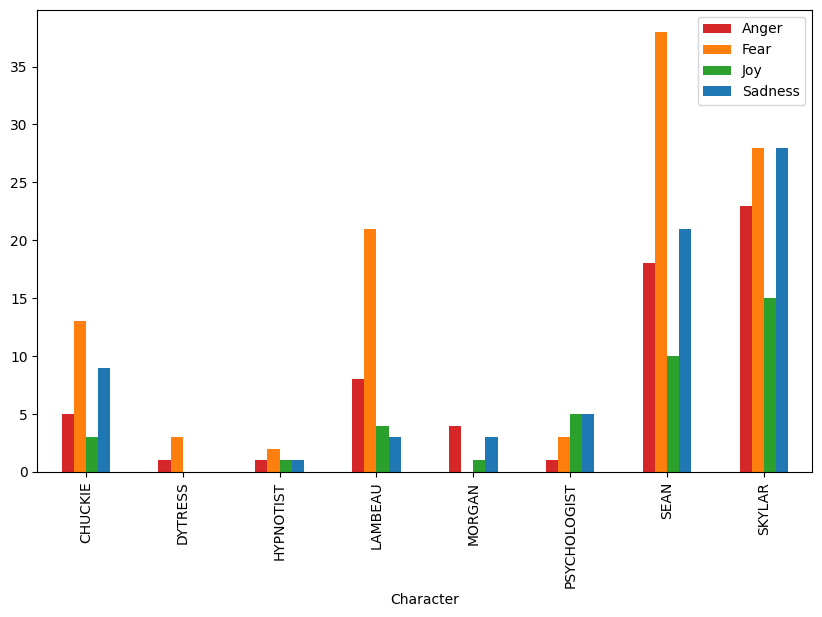

In [107]:
cmap={
    'Anger':'#d62728',
    'Sadness':'#ff7f0e',
    'Joy':'#2ca02c',
    'Fear':'#1f77b4' 
}

df = pd.DataFrame(emotions, columns=['Emotion', 'Name'])

df_pivot = df.pivot_table(index='Name', columns='Emotion', aggfunc='size', fill_value=0).reset_index()

df_pivot.columns.name = None  
emotions_expressed_per_ch = df_pivot.rename(columns={'Name': 'Character', 'anger': 'Anger', 'fear': 'Fear', 'sadness': 'Sadness', 'joy': 'Joy'})

emotions_expressed_per_ch.plot(x="Character",kind="bar",figsize=(10, 6),color=cmap.values())

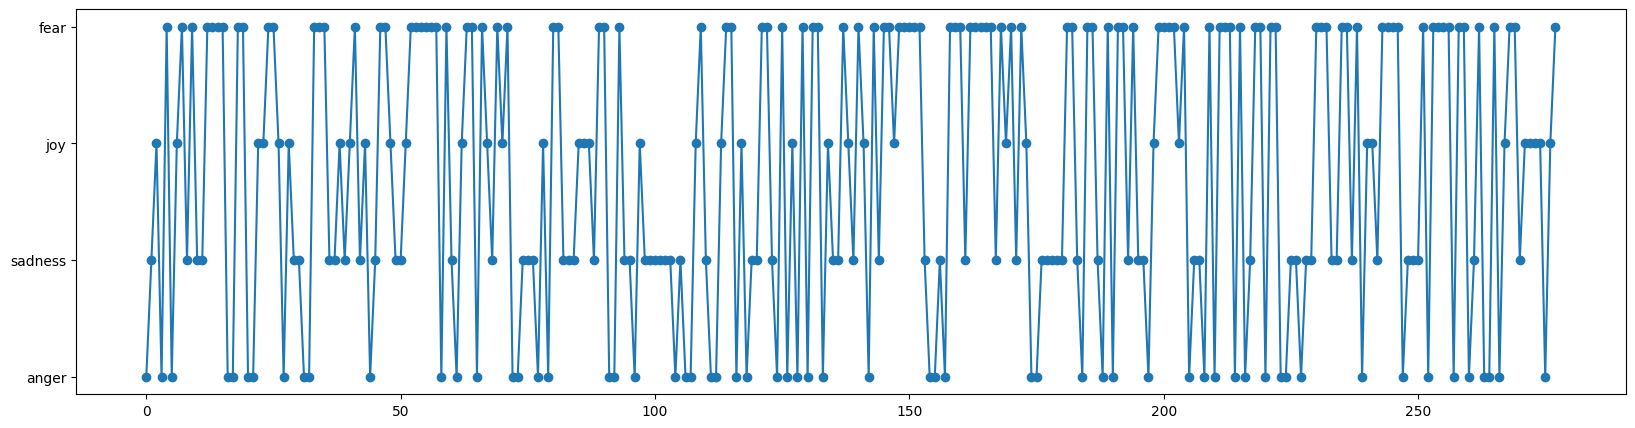

In [36]:
plt.plot(df.index, df["Emotion"], marker='o', linestyle='-')

<AxesSubplot:xlabel='Period'>

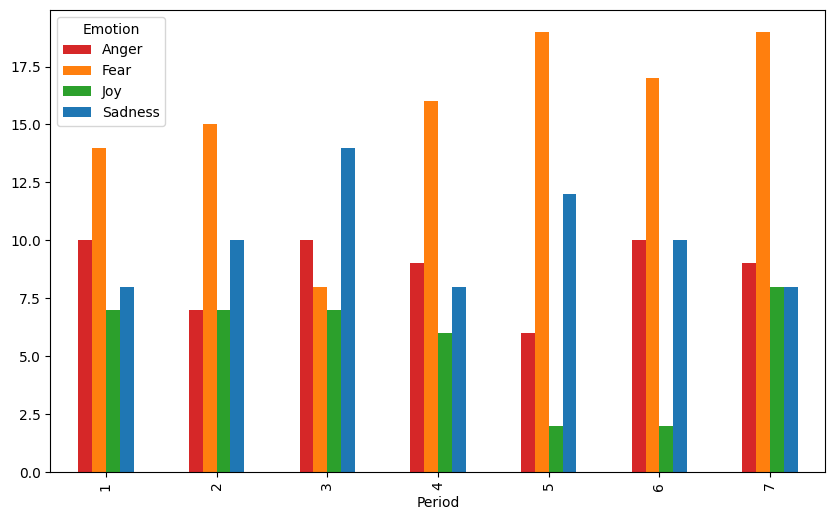

In [108]:

period_size = len(df) // 7
df['period'] = (df.index // period_size) + 1
df['period']=df['period'].apply(lambda x: 7 if x==8 else x) #

df_pivot = df.pivot_table(index='period', columns='Emotion', aggfunc='size', fill_value=0).reset_index()
df_pivot.columns.period = None  
emotions_in_time = df_pivot.rename(columns={'period': 'Period', 'anger': 'Anger', 'fear': 'Fear', 'sadness': 'Sadness', 'joy': 'Joy'})

emotions_in_time.plot(x="Period",kind="bar",figsize=(10, 6),color=cmap.values())

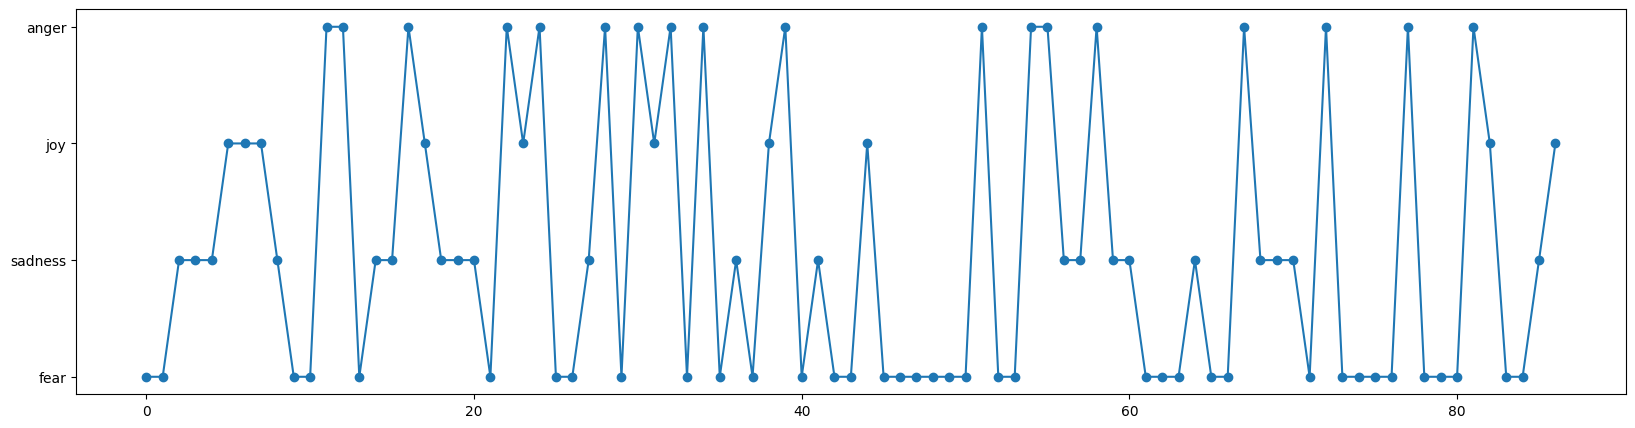

In [47]:
sean=df[df['Name']=="SEAN"].reset_index()
plt.plot(sean.index, sean["Emotion"], marker='o', linestyle='-')